In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/yfinance-stock-price-data-for-numerai-signals/full_data.parquet


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Axes(0.125,0.2;0.775x0.68)
Axes(0.125,0.2;0.775x0.68)


,signal,open,strat_return
date,,,
2002-01-14,0,34.150002,-0.017549
2002-01-22,0,33.305000,-0.007303
2002-02-13,1,30.129999,-0.003802
2002-02-15,0,30.850000,-0.004839
2002-03-08,1,31.815001,0.039027
2002-03-13,0,31.040001,-0.022516
2002-03-21,0,30.105000,-0.019381
2002-04-03,0,28.719999,-0.039947
2002-04-10,0,27.559999,-0.038549


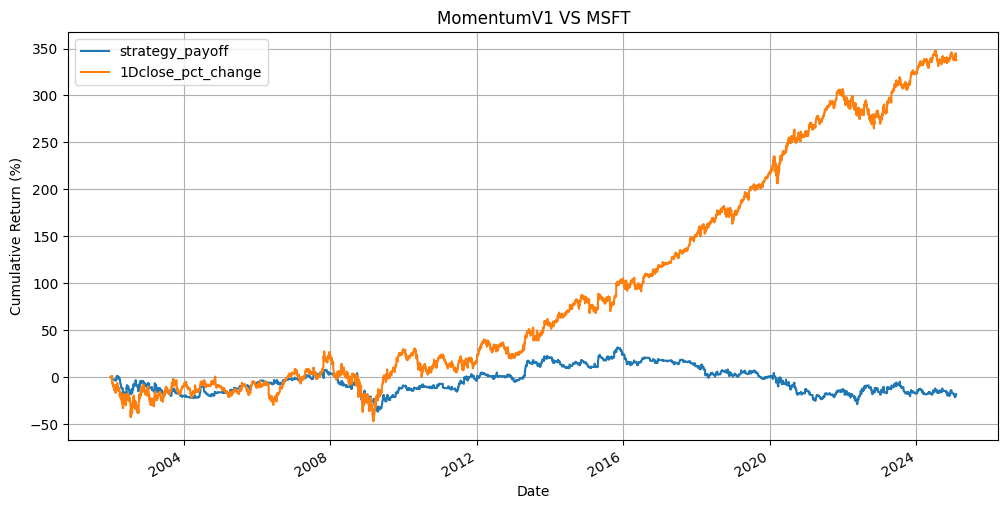

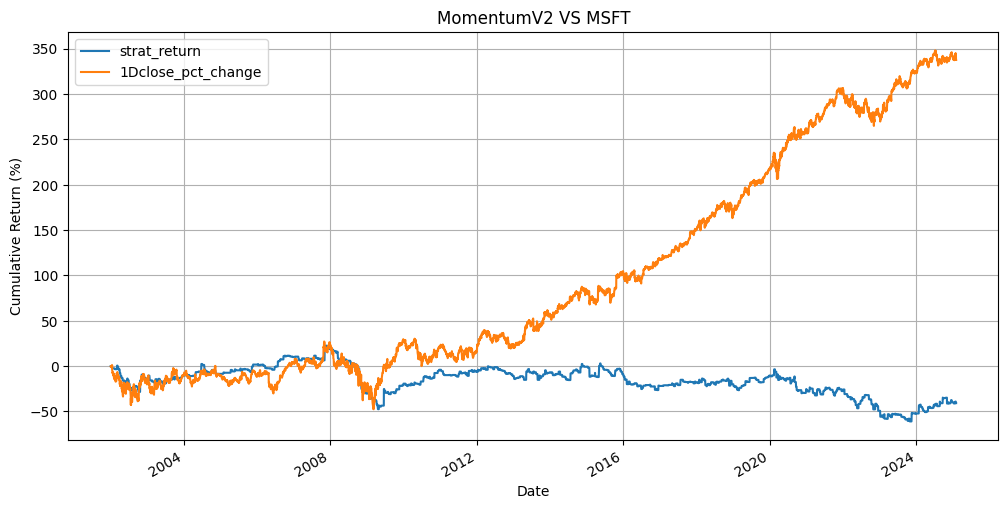

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_all = pd.read_parquet("/kaggle/input/yfinance-stock-price-data-for-numerai-signals/full_data.parquet")

df_all["date"] = pd.to_datetime(df_all["date"], format = "%Y%m%d")
df_all.set_index("date", inplace=True)

#simple momentum strategy (buy open next day if 3 day change > 1%)
#use panda filtering for just one stock (microsoft)
df = df_all[df_all["ticker"]== "MSFT"].copy()
#add a column for % change from prev. close
df["1Dclose_pct_change"] = df["raw_close"].pct_change()
df["3D_momentum"] = df["1Dclose_pct_change"].rolling(3).sum()
df["signal"] = (df["3D_momentum"] > 0.01).astype(int) #convert boolean to 1/0 (buy/hold)
#df["strategy_return"] = df["1Dclose_pct_change"] * df["signal"].shift(1) 
#shift as we can only act the next day

#this assumes we buy at close price (but no signal availiable yet) modification:

df["intraday_pct_change"] = (df["raw_close"] - df["open"]) / df["open"]
df["strategy_payoff"] = df["intraday_pct_change"] * df["signal"].shift(1)

#make new dataframe to then plot (each as percentage)
cum_sum = df[["strategy_payoff", "1Dclose_pct_change"]].cumsum() * 100

axes = cum_sum.plot(figsize=(12, 6), title = "MomentumV1 VS MSFT")
axes.set_xlabel("Date")
axes.set_ylabel("Cumulative Return (%)")
axes.grid(True)

print(axes)

#iloc/loc practice
#characters = {"Name" : ["Corbyn", "Trump", "Starmer", "Merz", "Macron"],
#"Height": [170, 130, 160, 182, 175], 
#"fav_num" : [3, 200, 45, 56, 45]
#}
#df_test = pd.DataFrame(data = characters)
#print(df_test)
#we automatically get an index column
#for the third column, then just the height
#print(df_test.loc[2]) 
#df_test.iloc[2] does the same here
#print(df_test.loc[2]["Height"])
#our dataframe is indexed by date so we'd need to use iloc

#now try to stay in the trade until signal disappears, not just taking the intraday following signal
#will use a for loop, now we care about entry and exit price as that will be our return 
#tracking if we are in market and storing entries + exits
df["strat_return"] = 0.0
trading = False
entry_price = 0.0
exit_price = 0.0


#we care about comparing yesterday signal to today 
for i in range (1, len(df)-1):
    prev_signal = df["signal"].iloc[i-1]
    current_signal = df["signal"].iloc[i] 
    #not trading yet see a change to enter
    if trading == False and prev_signal == 0 and current_signal == 1:
        entry_price = df["open"].iloc[i+1] #as we enter next day
        trading = True
    #in trade but momentum signal disappears
    elif trading == True and prev_signal == 1 and current_signal == 0:
        trading = False
        exit_price = df["open"].iloc[i+1]
        trade_pct_change = (exit_price - entry_price) / entry_price
        df.loc[df.index[i+1], "strat_return"] = trade_pct_change

cum_sum2 = df[["strat_return", "1Dclose_pct_change"]].cumsum() * 100
axes_2 = cum_sum2.plot(figsize=(12, 6), title = "MomentumV2 VS MSFT")
axes_2.set_xlabel("Date")
axes_2.set_ylabel("Cumulative Return (%)")
axes_2.grid(True)

print(axes)
#checking 
df[["signal", "open", "strat_return"]].loc[df["strat_return"] != 0].head(30)





